# DC Field Carrier Transport in Quantum Wires

:::{abstract}
This example demonstrates how to simulate carrier transport in a quantum wire under an applied DC electric field using the `pulsesuite.PSTD3D.dcfield` module. We investigate drift velocities, carrier distribution evolution, and phonon-assisted transport mechanisms.
:::

## Theory

The DC field transport module calculates the contribution of an applied electric field to the Semiconductor Bloch Equations (SBEs). The evolution of carrier distributions $f_{e/h}(k)$ includes a drift term:

$$
\left. \frac{\partial f}{\partial t} \right|_{DC} = -\frac{1}{\hbar} (-q E_{dc} - F_{drift}) \frac{\partial f}{\partial k}
$$

where $q = -e$ for electrons and $q = +e$ for holes, $E_{dc}$ is the DC electric field, and $F_{drift}$ is the drift force due to phonon interactions.

### Energy Renormalization

The renormalized energy includes many-body Hartree-Fock corrections:

$$
E_c(k) = E_n(k) + \frac{1}{2}\sum_{k'} f(k') \left[ V(k,k) - V(k,k') \right]
$$

### Drift Velocity

The average drift velocity is calculated from the energy gradient:

$$
v_{drift} = \frac{\sum_k \frac{dE_c}{dk}(k) \cdot f(k)}{\hbar \sum_k f(k)}
$$

### Phonon-Assisted Drift Force

The drift force $F_{drift}(k)$ accounts for phonon emission and absorption:

$$
F_{drift}(k) = \sum_q \hbar k \cdot \left[ \Gamma_{em}(k,q) - \Gamma_{abs}(k,q) \right]
$$

where $\Gamma_{em}$ and $\Gamma_{abs}$ are the emission and absorption rates computed using Lorentzian line shapes.

## Setup and Initialization

First, we import the necessary modules and set up the physical parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pulsesuite.PSTD3D.dcfield as dcfield
from scipy.constants import e as e0, hbar

# Physical Parameters for GaAs Quantum Wire
L_wire = 200e-9          # Wire length (m)
N_k = 256                # Momentum grid points
m_e = 0.067 * 9.109e-31  # Electron effective mass (kg)
m_h = 0.45 * 9.109e-31   # Hole effective mass (kg)
E_phonon = 0.036 * e0    # LO Phonon energy (~36 meV)
E_dc = 5e4               # Applied DC Field (50 kV/cm)
gamma_e = 1e12           # Electron scattering rate (Hz)
gamma_h = 1e12           # Hole scattering rate (Hz)
N0_phonon = 0.0          # Phonon occupation (T=0 K)

# Initialize Momentum Grid
k_grid = dcfield.GetKArray(N_k, L_wire)
dk = k_grid[1] - k_grid[0]
print(f"Momentum grid: {k_grid.min():.2e} to {k_grid.max():.2e} m^-1")
print(f"Grid spacing: {dk:.2e} m^-1")

# Initialize DC Field Module
dcfield.InitializeDC(k_grid, m_e, m_h)
print("DC field module initialized")

Momentum grid: -4.02e+09 to 3.99e+09 m^-1
Grid spacing: 3.14e+07 m^-1
DC field module initialized


## Initial Carrier Distributions

We create initial Gaussian distributions for electrons and holes.

In [2]:
# Initial Electron Distribution (Gaussian centered at k=0)
sigma_k = 2e8
n_e = np.exp(-k_grid**2 / (2 * sigma_k**2)) + 0j
n_e /= np.sum(n_e)  # Normalize

# Initial Hole Distribution
n_h = np.exp(-k_grid**2 / (2 * sigma_k**2)) + 0j
n_h /= np.sum(n_h)  # Normalize

# Single-particle energies
E_e = hbar**2 * k_grid**2 / (2 * m_e)
E_h = hbar**2 * k_grid**2 / (2 * m_h)

# Interaction matrices (simplified - no Coulomb for this demo)
V_ee = np.zeros((N_k, N_k))
V_hh = np.zeros((N_k, N_k))

# Phonon coupling constant (momentum-dependent)
C_q2 = np.ones(N_k) * 1e-18   # Constant coupling for simplicity

print(f"Initial electron density: {np.sum(np.real(n_e)):.4f}")
print(f"Initial hole density: {np.sum(np.real(n_h)):.4f}")

Initial electron density: 1.0000
Initial hole density: 1.0000


## Calculating DC Field Contributions

We compute the DC field contribution to the electron distribution evolution using the finite difference method (`CalcDCE2`).

In [3]:
# Output arrays for DC contributions
DC_e = np.zeros(N_k)
DC_h = np.zeros(N_k)

# Time step and iteration indices
n_step = 0
iteration = 0

# Calculate DC field contribution for electrons
dcfield.CalcDCE2(
    DCTrans=True,        # Enable DC transport
    ky=k_grid,
    Cq2=C_q2,
    Edc=E_dc,
    me=m_e,
    ge=gamma_e,
    Ephn=E_phonon,
    N0=N0_phonon,
    ne=n_e,
    Ee=E_e,
    Vee=V_ee,
    n=n_step,
    j=iteration,
    DC=DC_e
)

# Calculate DC field contribution for holes
dcfield.CalcDCH2(
    DCTrans=True,        # Enable DC transport
    ky=k_grid,
    Cq2=C_q2,
    Edc=E_dc,
    mh=m_h,
    gh=gamma_h,
    Ephn=E_phonon,
    N0=N0_phonon,
    nh=n_h,
    Eh=E_h,
    Vhh=V_hh,
    n=n_step,
    j=iteration,
    DC=DC_h
)

print(f"Electron drift rate: {dcfield.GetEDrift():.2e} Hz")
print(f"Hole drift rate: {dcfield.GetHDrift():.2e} Hz")
print(f"Electron drift velocity: {dcfield.GetVEDrift():.2e} m/s")
print(f"Hole drift velocity: {dcfield.GetVHDrift():.2e} m/s")

Electron drift rate: 2.41e+36+0.00e+00j Hz
Hole drift rate: 1.69e+35+0.00e+00j Hz
Electron drift velocity: 1.08e-11 m/s
Hole drift velocity: -2.60e-12 m/s


## Current Calculation

We calculate the total current from the carrier distributions.

In [4]:
# Calculate electron current
I_e = dcfield.CalcI0n(n_e, m_e, k_grid)
print(f"Electron current: {I_e:.2e} A")

# Calculate total current (requires interaction matrix structure)
# For this demo, we use a simplified version
VC = np.zeros((N_k, N_k, 3))
VC[:, :, 1] = V_ee  # Electron-electron
VC[:, :, 2] = V_hh  # Hole-hole

I_total = dcfield.CalcI0(n_e, n_h, E_e, E_h, VC, dk, k_grid, 0.0)
print(f"Total current: {I_total:.2e} A")

Electron current: -0.00e+00+0.00e+00j A
Total current: -1.30e-23+0.00e+00j A


## Visualization

We visualize the initial distributions and the DC field contributions.

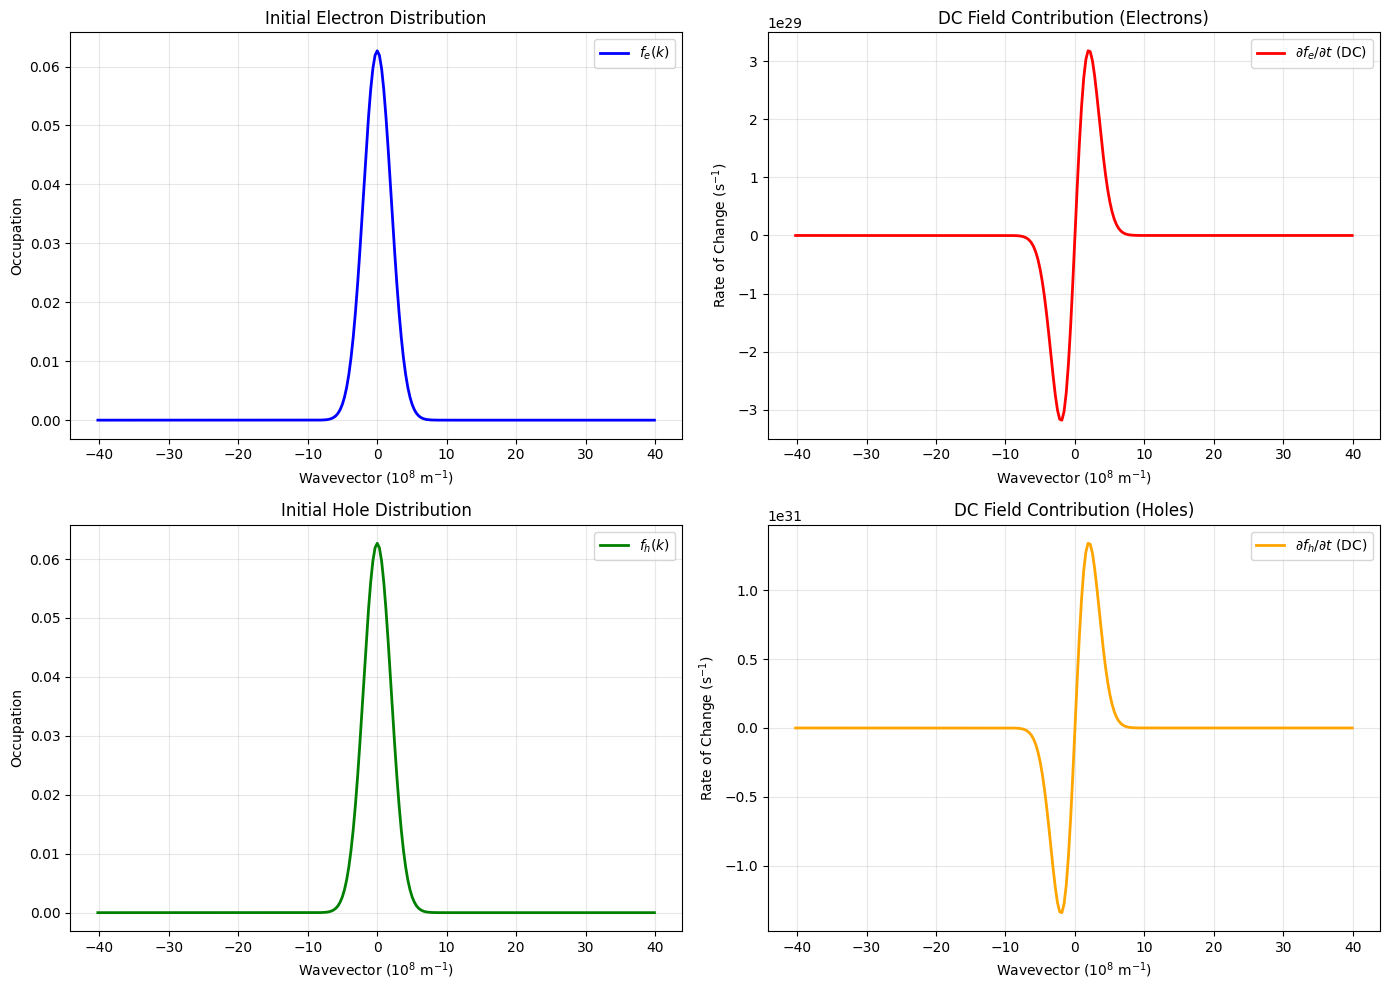

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Electron distribution
ax = axes[0, 0]
ax.plot(k_grid/1e8, np.real(n_e), 'b-', label='$f_e(k)$', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Occupation')
ax.set_title('Initial Electron Distribution')
ax.grid(True, alpha=0.3)
ax.legend()

# Electron DC contribution
ax = axes[0, 1]
ax.plot(k_grid/1e8, DC_e, 'r-', label='$\\partial f_e/\\partial t$ (DC)', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Rate of Change (s$^{-1}$)')
ax.set_title('DC Field Contribution (Electrons)')
ax.grid(True, alpha=0.3)
ax.legend()

# Hole distribution
ax = axes[1, 0]
ax.plot(k_grid/1e8, np.real(n_h), 'g-', label='$f_h(k)$', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Occupation')
ax.set_title('Initial Hole Distribution')
ax.grid(True, alpha=0.3)
ax.legend()

# Hole DC contribution
ax = axes[1, 1]
ax.plot(k_grid/1e8, DC_h, 'orange', label='$\\partial f_h/\\partial t$ (DC)', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Rate of Change (s$^{-1}$)')
ax.set_title('DC Field Contribution (Holes)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

:::{note}
The DC contribution shows the rate of change of the distribution. For electrons, the negative charge means they drift opposite to the field direction. The asymmetry in the DC contribution indicates the direction of carrier drift.
:::

## Comparison: FFT vs Finite Difference Methods

The module provides two implementations: `CalcDCE`/`CalcDCH` (FFT-based) and `CalcDCE2`/`CalcDCH2` (finite difference). Let's compare them.

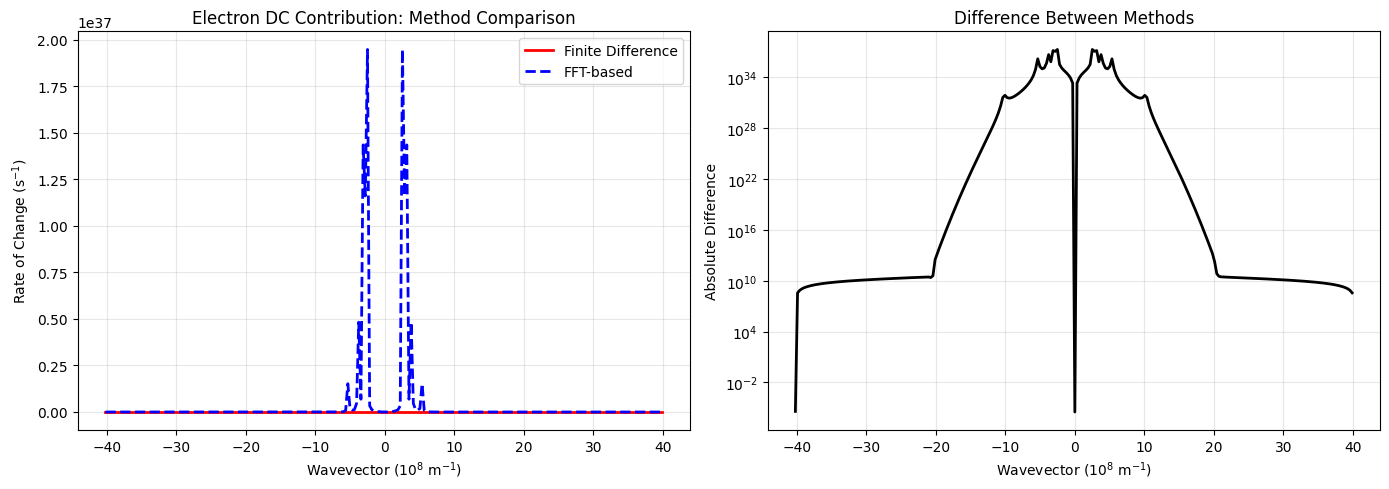

In [6]:
# FFT-based method
DC_e_fft = np.zeros(N_k)
DC_h_fft = np.zeros(N_k)

dcfield.CalcDCE(
    DCTrans=True,
    ky=k_grid,
    Cq2=C_q2,
    Edc=E_dc,
    me=m_e,
    ge=gamma_e,
    Ephn=E_phonon,
    N0=N0_phonon,
    ne=n_e,
    Ee=E_e,
    Vee=V_ee,
    DC=DC_e_fft
)

dcfield.CalcDCH(
    DCTrans=True,
    ky=k_grid,
    Cq2=C_q2,
    Edc=E_dc,
    mh=m_h,
    gh=gamma_h,
    Ephn=E_phonon,
    N0=N0_phonon,
    nh=n_h,
    Eh=E_h,
    Vhh=V_hh,
    DC=DC_h_fft
)

# Compare the two methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(k_grid/1e8, DC_e, 'r-', label='Finite Difference', linewidth=2)
ax.plot(k_grid/1e8, DC_e_fft, 'b--', label='FFT-based', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Rate of Change (s$^{-1}$)')
ax.set_title('Electron DC Contribution: Method Comparison')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.plot(k_grid/1e8, np.abs(DC_e - DC_e_fft), 'k-', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Absolute Difference')
ax.set_title('Difference Between Methods')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

:::{tip}
The finite difference method (`CalcDCE2`/`CalcDCH2`) is generally more stable and easier to debug, while the FFT method (`CalcDCE`/`CalcDCH`) can be faster for large grids but may have boundary effects.
:::

## Drift Velocity Evolution

We can track how the drift velocity changes with the distribution. Let's calculate it directly from the distribution.

In [7]:
# Calculate drift velocity from distribution
v_e_dist = dcfield.CalcVD(k_grid, m_e, n_e)
v_h_dist = dcfield.CalcVD(k_grid, m_h, n_h)

print(f"Electron drift velocity (from distribution): {v_e_dist:.2e} m/s")
print(f"Hole drift velocity (from distribution): {v_h_dist:.2e} m/s")

# Calculate average momentum
p_e = dcfield.CalcPD(k_grid, m_e, n_e)
p_h = dcfield.CalcPD(k_grid, m_h, n_h)

print(f"Electron average momentum: {p_e:.2e} kg·m/s")
print(f"Hole average momentum: {p_h:.2e} kg·m/s")

Electron drift velocity (from distribution): -2.91e-11 m/s
Hole drift velocity (from distribution): -3.64e-12 m/s
Electron average momentum: 0.00e+00 kg·m/s
Hole average momentum: 0.00e+00 kg·m/s


## Energy Renormalization

The module includes energy renormalization to account for many-body effects. Let's examine this.

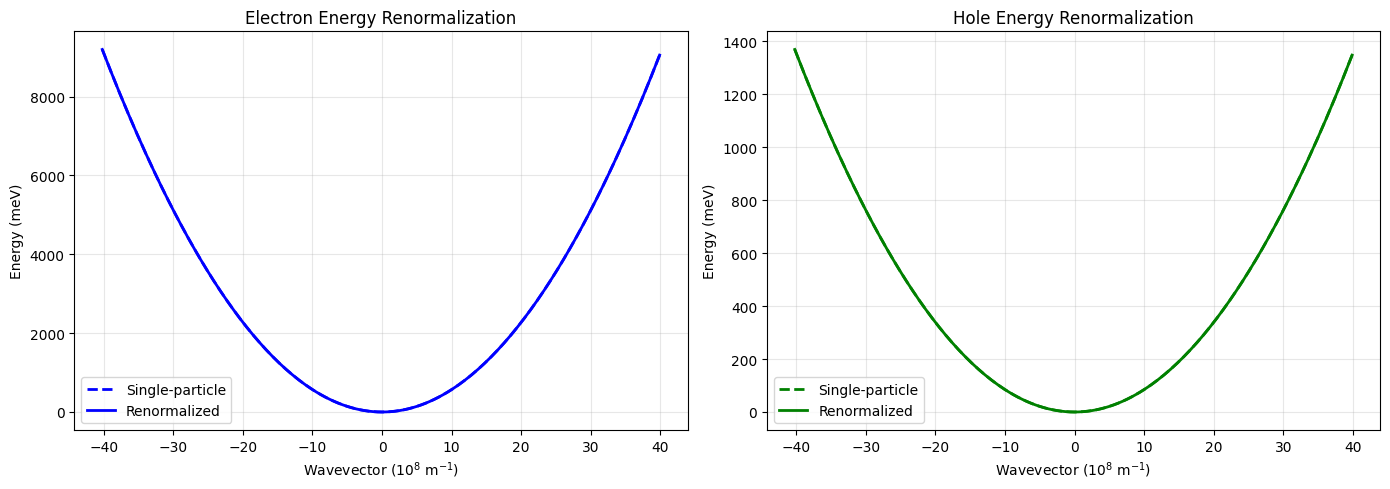

In [8]:
# Calculate renormalized energies
E_e_renorm = dcfield.EkReNorm(np.real(n_e), E_e, V_ee)
E_h_renorm = dcfield.EkReNorm(np.real(n_h), E_h, V_hh)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(k_grid/1e8, E_e/e0*1e3, 'b--', label='Single-particle', linewidth=2)
ax.plot(k_grid/1e8, E_e_renorm/e0*1e3, 'b-', label='Renormalized', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Energy (meV)')
ax.set_title('Electron Energy Renormalization')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.plot(k_grid/1e8, E_h/e0*1e3, 'g--', label='Single-particle', linewidth=2)
ax.plot(k_grid/1e8, E_h_renorm/e0*1e3, 'g-', label='Renormalized', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Energy (meV)')
ax.set_title('Hole Energy Renormalization')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

:::{note}
For this example with zero Coulomb interaction ($V_{ee} = V_{hh} = 0$), the renormalized energy equals the single-particle energy. In realistic simulations with Coulomb interactions, the renormalization shifts the energy bands.
:::

## Summary

This example demonstrated:

1. **Initialization** of the DC field module with momentum grids and carrier masses
2. **DC field contribution calculation** using both FFT and finite difference methods
3. **Drift velocity** computation from carrier distributions
4. **Current calculation** from electron and hole distributions
5. **Energy renormalization** accounting for many-body effects
6. **Phonon-assisted transport** through the drift force calculation

The `dcfield` module provides a comprehensive framework for simulating carrier transport in quantum wires under applied DC fields, including phonon scattering and many-body interactions.